In [2]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")


LOAD DATA

In [3]:
import sys
sys.path.append("../src")

from data_loader import load_data

df = load_data("../data/raw/sales.csv")
df.head()


Script started
Loading CSV...
Original columns: Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')


,store,date,sales,holiday_flag,temperature,fuel_price,cpi,unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   store         6435 non-null   int64         
 1   date          6435 non-null   datetime64[ns]
 2   sales         6435 non-null   float64       
 3   holiday_flag  6435 non-null   int64         
 4   temperature   6435 non-null   float64       
 5   fuel_price    6435 non-null   float64       
 6   cpi           6435 non-null   float64       
 7   unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


In [7]:
### MISSING VALUES

df.isnull().sum()


store           0
date            0
sales           0
holiday_flag    0
temperature     0
fuel_price      0
cpi             0
unemployment    0
dtype: int64

There are no missing values!!

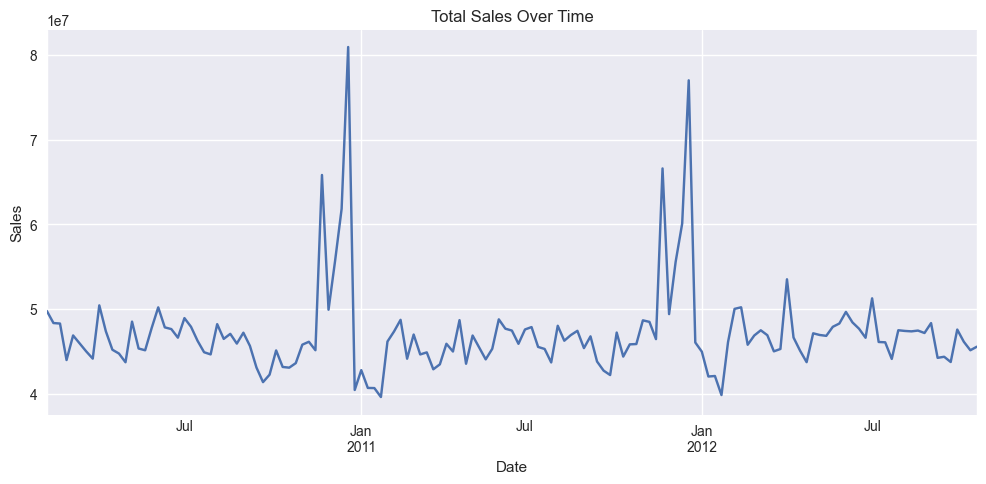

In [8]:
### TIME SERIES OVERVIEW

daily_sales = df.groupby("date")["sales"].sum()
daily_sales.plot(figsize=(12,5))
plt.title("Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


### Observations

- Overall sales remain relatively stable across the observed period with no strong long-term upward or downward trend.
- There are sharp, recurring spikes in sales around the end of each year (Nov–Dec), indicating strong seasonal effects.
- Immediately after these spikes, sales drop noticeably, suggesting post-holiday demand normalization.
- Outside of peak periods, sales fluctuate within a narrow range, indicating consistent baseline demand.

### Business Interpretation

- Year-end spikes are likely driven by holiday shopping and promotions.
- Post-holiday drops suggest potential overstock risk if inventory is not adjusted after peak season.
- Forecasting models must explicitly account for seasonal and holiday effects to avoid under- or over-predicting demand.


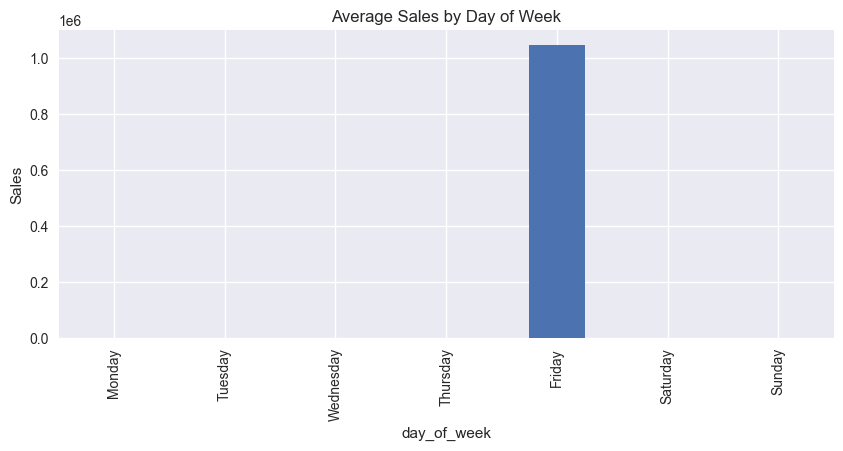

In [10]:
### SEASONALITY ANALYSIS

df["day_of_week"] = df["date"].dt.day_name()

dow_sales = df.groupby("day_of_week")["sales"].mean()
dow_sales = dow_sales.reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)

dow_sales.plot(kind="bar", figsize=(10,4))
plt.title("Average Sales by Day of Week")
plt.ylabel("Sales")
plt.show()


### Observations

- Average sales appear to be disproportionately high on Fridays compared to all other days of the week.
- Sales on Monday through Thursday and during the weekend are significantly lower and relatively similar to each other.
- This sharp Friday spike is not a smooth seasonal pattern and stands out as an anomaly rather than a gradual trend.

### Business Interpretation

- The unusually high Friday sales may be driven by data aggregation effects (e.g., weekly sales being recorded on a specific weekday rather than actual daily demand).
- This suggests that the dataset may not represent true daily sales behavior, but instead reflects reporting or accounting conventions.
- As a result, day-of-week seasonality should be treated with caution and not blindly assumed to reflect customer purchasing behavior.


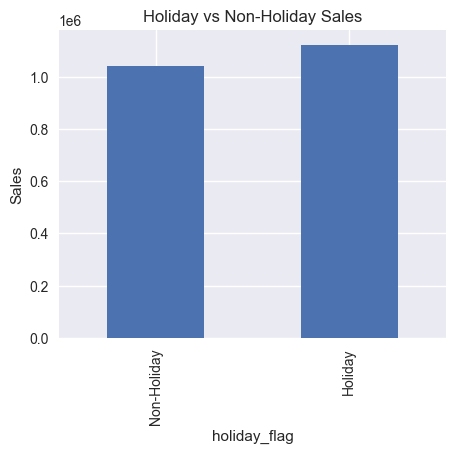

In [11]:
### HOLIDAY IMPACT

holiday_sales = df.groupby("holiday_flag")["sales"].mean()
holiday_sales.plot(kind="bar", figsize=(5,4))
plt.title("Holiday vs Non-Holiday Sales")
plt.xticks([0,1], ["Non-Holiday", "Holiday"])
plt.ylabel("Sales")
plt.show()


### Observations

- Average sales during holiday weeks are noticeably higher than during non-holiday weeks.
- The uplift is consistent rather than extreme, indicating a systematic holiday effect rather than random spikes.
- Non-holiday weeks show relatively stable average sales, reinforcing the reliability of the baseline demand.

### Business Interpretation

- Holidays drive a measurable increase in demand, likely due to promotional activity and increased customer spending.
- Ignoring holiday effects would lead to underestimation of demand during peak periods and potential stock-outs.
- Holiday indicators should be explicitly incorporated as features in the forecasting model.

### Modeling Implication

- A holiday_flag feature will be included in the forecasting pipeline.
- Separate evaluation of model performance on holiday vs non-holiday periods may be required to ensure robustness.


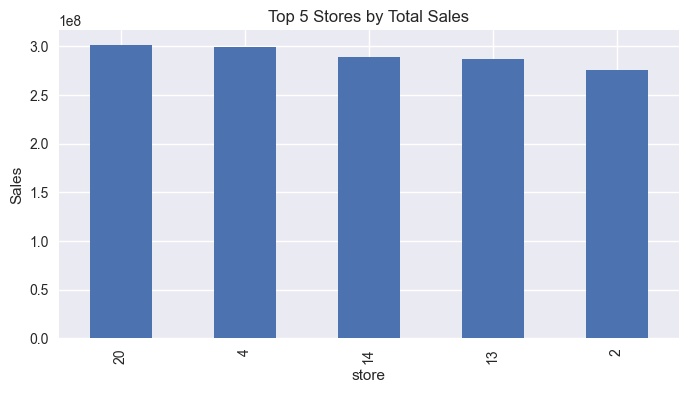

In [12]:
### STORE-LEVEL VARIATION

top_stores = (
    df.groupby("store")["sales"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
)

top_stores.plot(kind="bar", figsize=(8,4))
plt.title("Top 5 Stores by Total Sales")
plt.ylabel("Sales")
plt.show()


### Observations

- The top five stores contribute a disproportionately large share of total sales compared to the rest of the network.
- While the top stores have comparable sales volumes, there is still a noticeable gap between the highest- and lowest-performing stores within the top group.
- This indicates meaningful variability in demand across store locations.

### Business Interpretation

- Store-level heterogeneity suggests that demand drivers are not uniform across all stores.
- Applying a single global forecasting model may underperform for high-volume or low-volume stores.
- High-performing stores represent greater financial risk if forecasts are inaccurate due to their larger revenue contribution.

### Modeling Implication

- Store-level features should be included in the forecasting pipeline.
- Forecasting can be improved by either:
  - training separate models for high-volume vs low-volume stores, or
  - incorporating store identifiers and historical store-specific patterns into a global model.


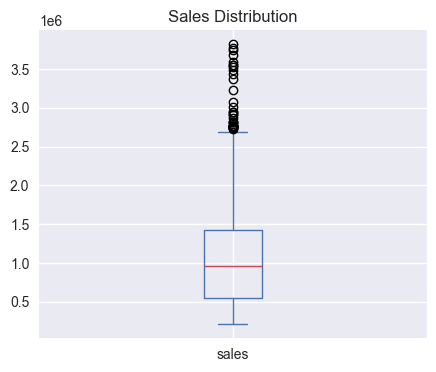

In [13]:
### OUTLIER CHECK

df["sales"].plot(kind="box", figsize=(5,4))
plt.title("Sales Distribution")
plt.show()


### Observations

- The sales distribution is right-skewed, with a majority of observations concentrated within a moderate range.
- There are several high-value outliers above the upper quartile, indicating occasional periods of unusually high sales.
- The presence of multiple extreme values suggests that sales spikes are not isolated incidents but occur repeatedly.

### Business Interpretation

- High sales outliers are likely associated with holiday periods, promotions, or high-performing stores rather than data errors.
- These extreme values represent genuine business events that carry significant revenue impact.
- Removing these outliers would risk underestimating peak demand and misrepresenting real-world sales behavior.

### Modeling Implication

- Outliers will be retained in the dataset, as they reflect valid demand surges.
- Robust modeling approaches and error metrics (e.g., MAE rather than MSE alone) should be considered to prevent extreme values from dominating model training.


## EDA Summary & Modeling Implications

- Total sales remain relatively stable over time, with no strong long-term upward or downward trend, but show recurring sharp spikes around year-end periods.
- These spikes are primarily driven by holiday weeks, followed by noticeable post-holiday demand drops, indicating strong seasonal demand behavior.
- Sales data is recorded at a weekly level, with dates representing week-ending periods; therefore, day-of-week patterns do not reflect true daily customer behavior and will not be used for modeling.
- Holiday weeks consistently show higher average sales compared to non-holiday weeks, making holiday indicators a critical exogenous feature.
- Significant variation exists across stores, with a small number of stores contributing a disproportionately large share of total sales.
- Sales distribution is right-skewed with multiple high-value outliers, which represent genuine demand surges rather than data errors.
- No critical missing values were observed in key variables required for forecasting.

### Modeling Decisions Based on EDA
- Forecasting will be performed at a weekly level to align with the data granularity.
- Lag-based features and rolling statistics will be included to capture temporal dependence.
- A holiday_flag feature will be incorporated to account for demand spikes during holiday periods.
- Store-level information will be included to capture heterogeneity across locations.
- Outliers will be retained, and robust evaluation metrics (e.g., MAE) will be preferred to reduce sensitivity to extreme values.
